In [1]:
import numpy as np
import matplotlib.pyplot as plt
import read_chroma
import plot
import peak_detection
import projection
import peak_simulation
import random
import utils
import importlib
import sklearn
from sklearn.cluster import DBSCAN
import mass_spec
from skimage.segmentation import watershed
from scipy import ndimage as ndi
import integration
from sklearn.cluster import AgglomerativeClustering

In [2]:
chromato_obj = read_chroma.read_chroma('./data/ELO_CDF/005_039_J7.cdf', 1.25)

In [3]:
chromato, time_rn, spectra_obj = chromato_obj

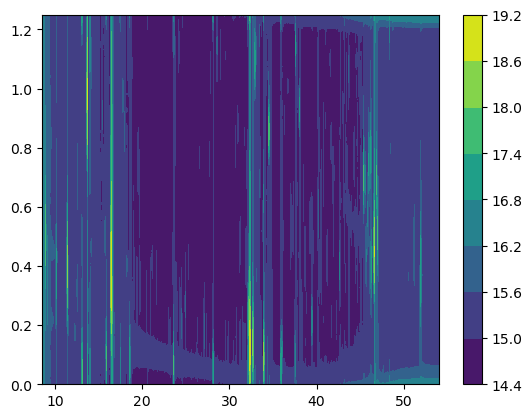

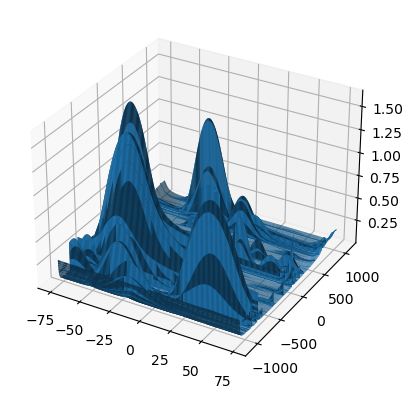

In [4]:
plot.visualizer((chromato,time_rn))
plot.plot_3d_chromato(chromato, cstride=1, rstride=1)

In [5]:
new_chroma = np.ones_like(chromato)

In [6]:
mu_peak_1 = (400,40)
mu_peak_2 = (395,45)
mu_peak_3 = (410,45)
int_peak_1=20000
int_peak_2=20000
int_peak_3=20000
sigma_peak_1=5.0
sigma_peak_2=5.0
sigma_peak_3=5.0
size=80

In [7]:
dist=np.sqrt((mu_peak_1[0] - mu_peak_2[0])**2 + (mu_peak_1[1] - mu_peak_2[1])**2)
dist

7.0710678118654755

# Create peak

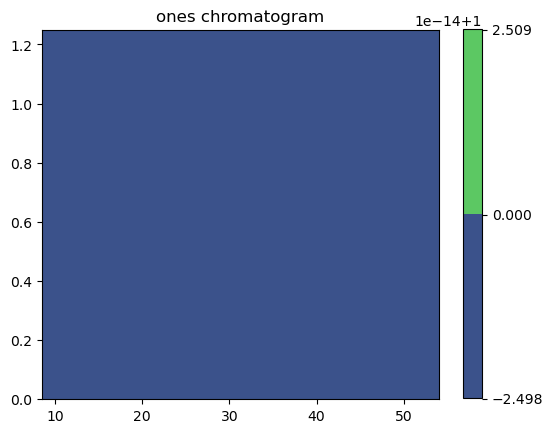

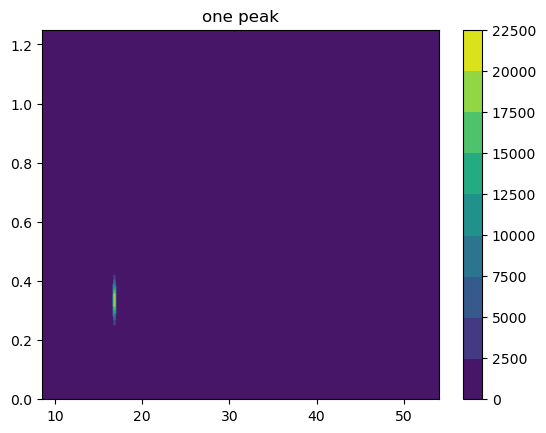

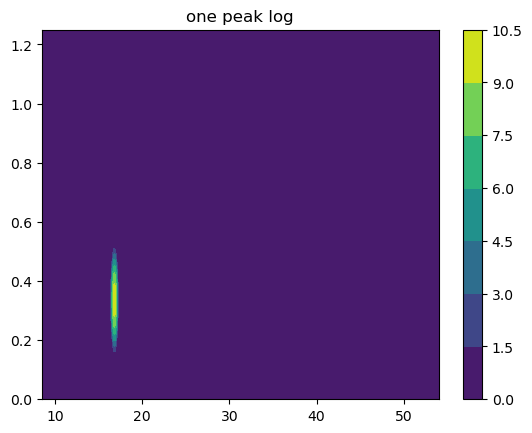

390 30


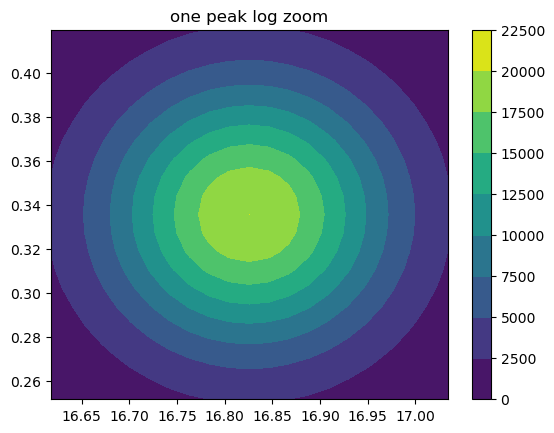

In [8]:
plot.visualizer((new_chroma, time_rn), log_chromato=False, title="ones chromatogram")
new_chroma_with_peak=peak_simulation.create_and_add_peak(new_chroma.copy(), size=size, intensity=int_peak_1, mu=mu_peak_1, sigma=sigma_peak_1)
plot.visualizer((new_chroma_with_peak, time_rn), log_chromato=False, title="one peak")
plot.visualizer((new_chroma_with_peak, time_rn), log_chromato=True, title="one peak log")
plot.visualizer((new_chroma_with_peak, time_rn), center_pt=[400,40], center_pt_window_1=10,center_pt_window_2=10, log_chromato=False, title="one peak log zoom")

# Add an other peak

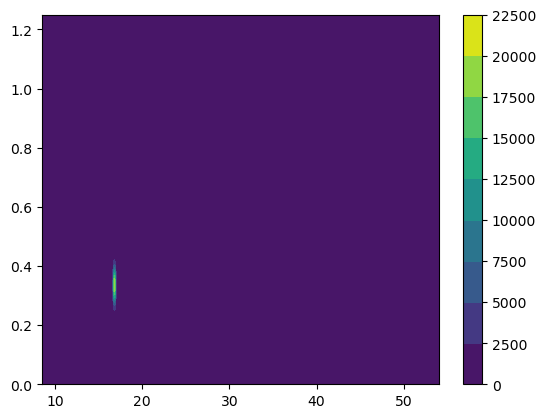

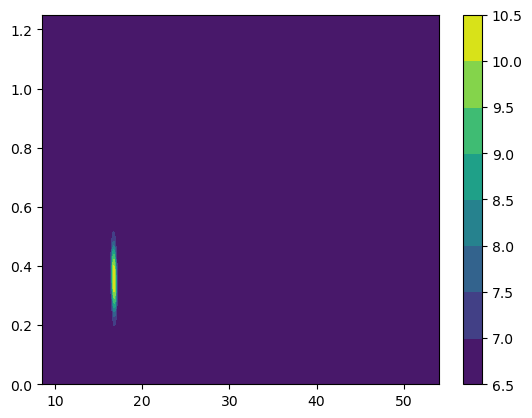

370 10


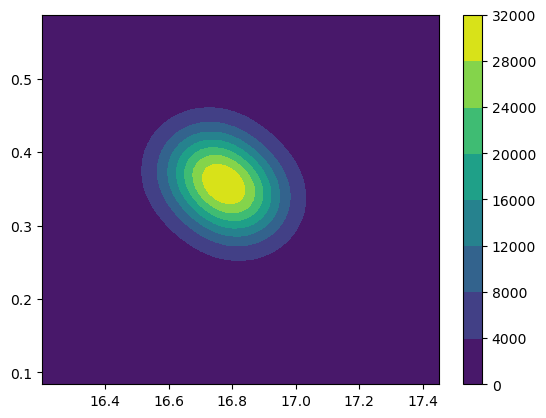

In [9]:
plot.visualizer((new_chroma_with_peak, time_rn), log_chromato=False)
# add peak
new_chroma_with_2_peaks=peak_simulation.create_and_add_peak(new_chroma_with_peak.copy(), size=size, intensity=int_peak_2, mu=mu_peak_2, sigma=sigma_peak_2)
# add gaussian white noise and cst baseline
cst=1000
new_chroma_with_2_peaks= peak_simulation.add_noise("gauss", new_chroma_with_2_peaks) + cst
plot.visualizer((new_chroma_with_2_peaks, time_rn), log_chromato=True)
plot.visualizer((new_chroma_with_2_peaks, time_rn), center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, log_chromato=False)


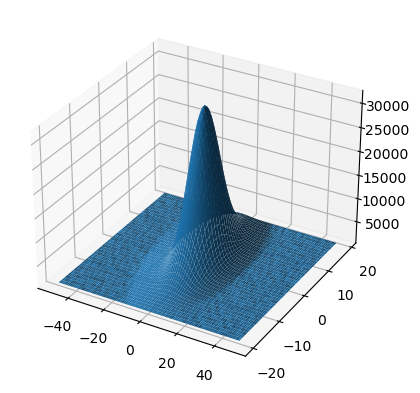

In [10]:
plot.plot_3d_chromato(new_chroma_with_2_peaks[350:450, 20:60].T, cstride=1, rstride=1)

# Peak detection

In [11]:
u = peak_detection.peak_detection(chromato_obj=(new_chroma_with_2_peaks, time_rn, spectra_obj), spectra=None, chromato_cube=None, seuil=0.1, ABS_THRESHOLDS=None, method='peak_local_max')
u

array([[398,  42]], dtype=int64)

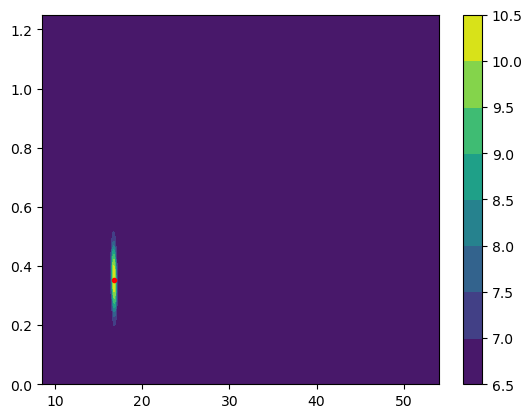

370 10


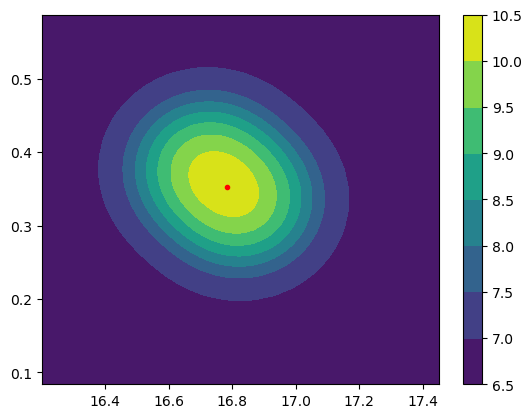

In [12]:
coordinates_in_chromato = projection.matrix_to_chromato(u, time_rn, 1.25, chromato.shape)
plot.visualizer((new_chroma_with_2_peaks, time_rn), log_chromato=True, points=coordinates_in_chromato)
plot.visualizer((new_chroma_with_2_peaks, time_rn), center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, log_chromato=True, points=coordinates_in_chromato)


Two overlapped peaks, need spectra fo find two peaks

# Create chromato from spectra

In [13]:
nb_mass=120

In [14]:
#mass values range
mass_values = np.linspace(0, nb_mass-1, nb_mass).astype(int)
spectrum1 = peak_simulation.create_random_mass_spectra(nb_mass)
spectrum2 = peak_simulation.create_random_mass_spectra(nb_mass)

In [15]:
spectrum3 = peak_simulation.create_random_mass_spectra(nb_mass)

In [16]:
#create chromato_cube
chromato_cube = np.zeros((chromato.shape[0], chromato.shape[1], nb_mass))

In [17]:
chromato_cube_with_one_peak = peak_simulation.create_and_add_peak_spectrum(chromato_cube.copy(), 40, int_peak_1, mu_peak_1, spectrum1, sigma=sigma_peak_1)

In [18]:
noisy_chromato_cube_with_one_peak = peak_simulation.add_chromato_cube_gaussian_white_noise(chromato_cube_with_one_peak)

In [19]:
chromato_cube_with_two_peaks = peak_simulation.create_and_add_peak_spectrum(chromato_cube_with_one_peak.copy(), 40, int_peak_2, mu_peak_2, spectrum2, sigma=sigma_peak_2)

In [20]:
noisy_chromato_cube_with_two_peaks = peak_simulation.add_chromato_cube_gaussian_white_noise(chromato_cube_with_two_peaks)

In [21]:
chromato_cube_with_three_peaks = peak_simulation.create_and_add_peak_spectrum(chromato_cube_with_two_peaks.copy(), 40, int_peak_3, mu_peak_3, spectrum3, sigma=sigma_peak_3)
noisy_chromato_cube_with_three_peaks =  peak_simulation.add_chromato_cube_gaussian_white_noise(chromato_cube_with_three_peaks)
chromato_TIC_three_peaks=np.sum(noisy_chromato_cube_with_three_peaks, -1)

In [22]:
#delete peak
noisy_chromato_cube_delete_peak = peak_simulation.delete_peak(noisy_chromato_cube_with_two_peaks.copy(), 40, int_peak_2, mu_peak_2, spectrum2, sigma=sigma_peak_2)

In [23]:
chromato_TIC_two_peaks = np.sum(noisy_chromato_cube_with_two_peaks, -1)
print(chromato_TIC_two_peaks.shape)

(2187, 150)


In [24]:
chromato_TIC_one_peak =  np.sum(noisy_chromato_cube_with_one_peak, -1)

In [25]:
#chromato delete peak
chromato_TIC_delete_peak = np.sum(noisy_chromato_cube_delete_peak, -1)
print(chromato_TIC_two_peaks.shape)

(2187, 150)


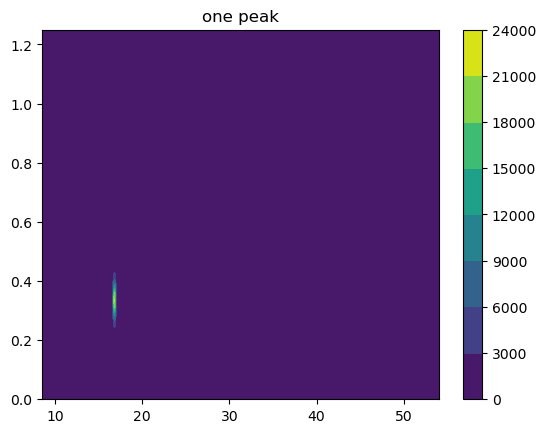

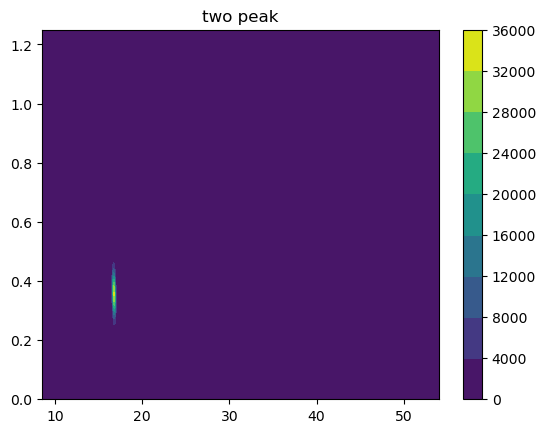

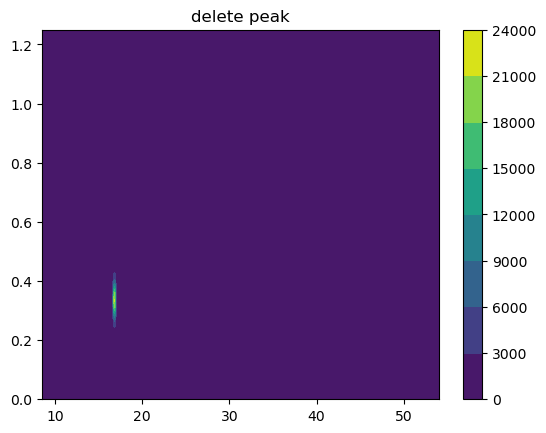

370 10


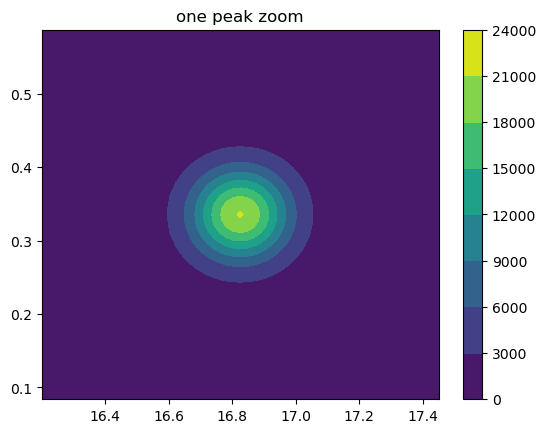

370 10


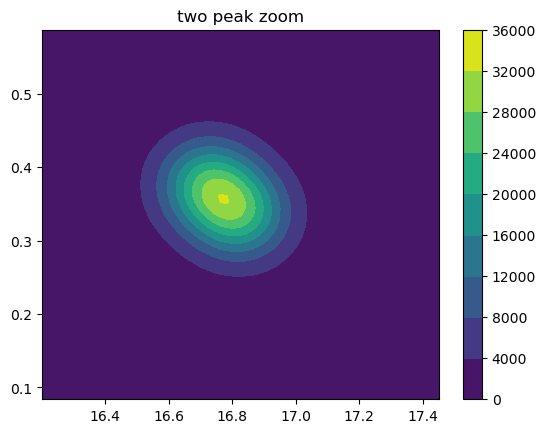

370 10


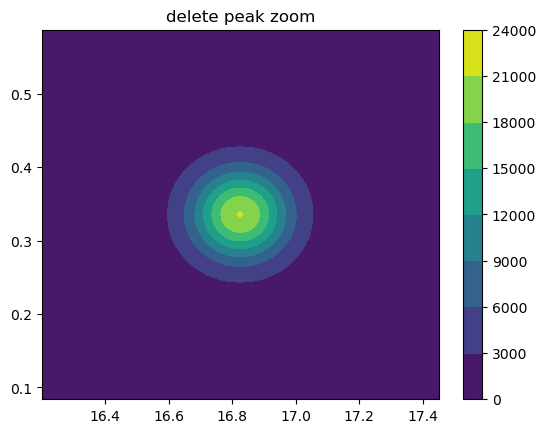

In [26]:
plot.visualizer((chromato_TIC_one_peak, time_rn), log_chromato=False, title='one peak')
plot.visualizer((chromato_TIC_two_peaks, time_rn), log_chromato=False, title='two peak')
plot.visualizer((chromato_TIC_delete_peak, time_rn), log_chromato=False, title='delete peak')
plot.visualizer((chromato_TIC_one_peak, time_rn), log_chromato=False, center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, title='one peak zoom')
plot.visualizer((chromato_TIC_two_peaks, time_rn), log_chromato=False, center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, title='two peak zoom')
plot.visualizer((chromato_TIC_delete_peak, time_rn), log_chromato=False, center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, title='delete peak zoom')


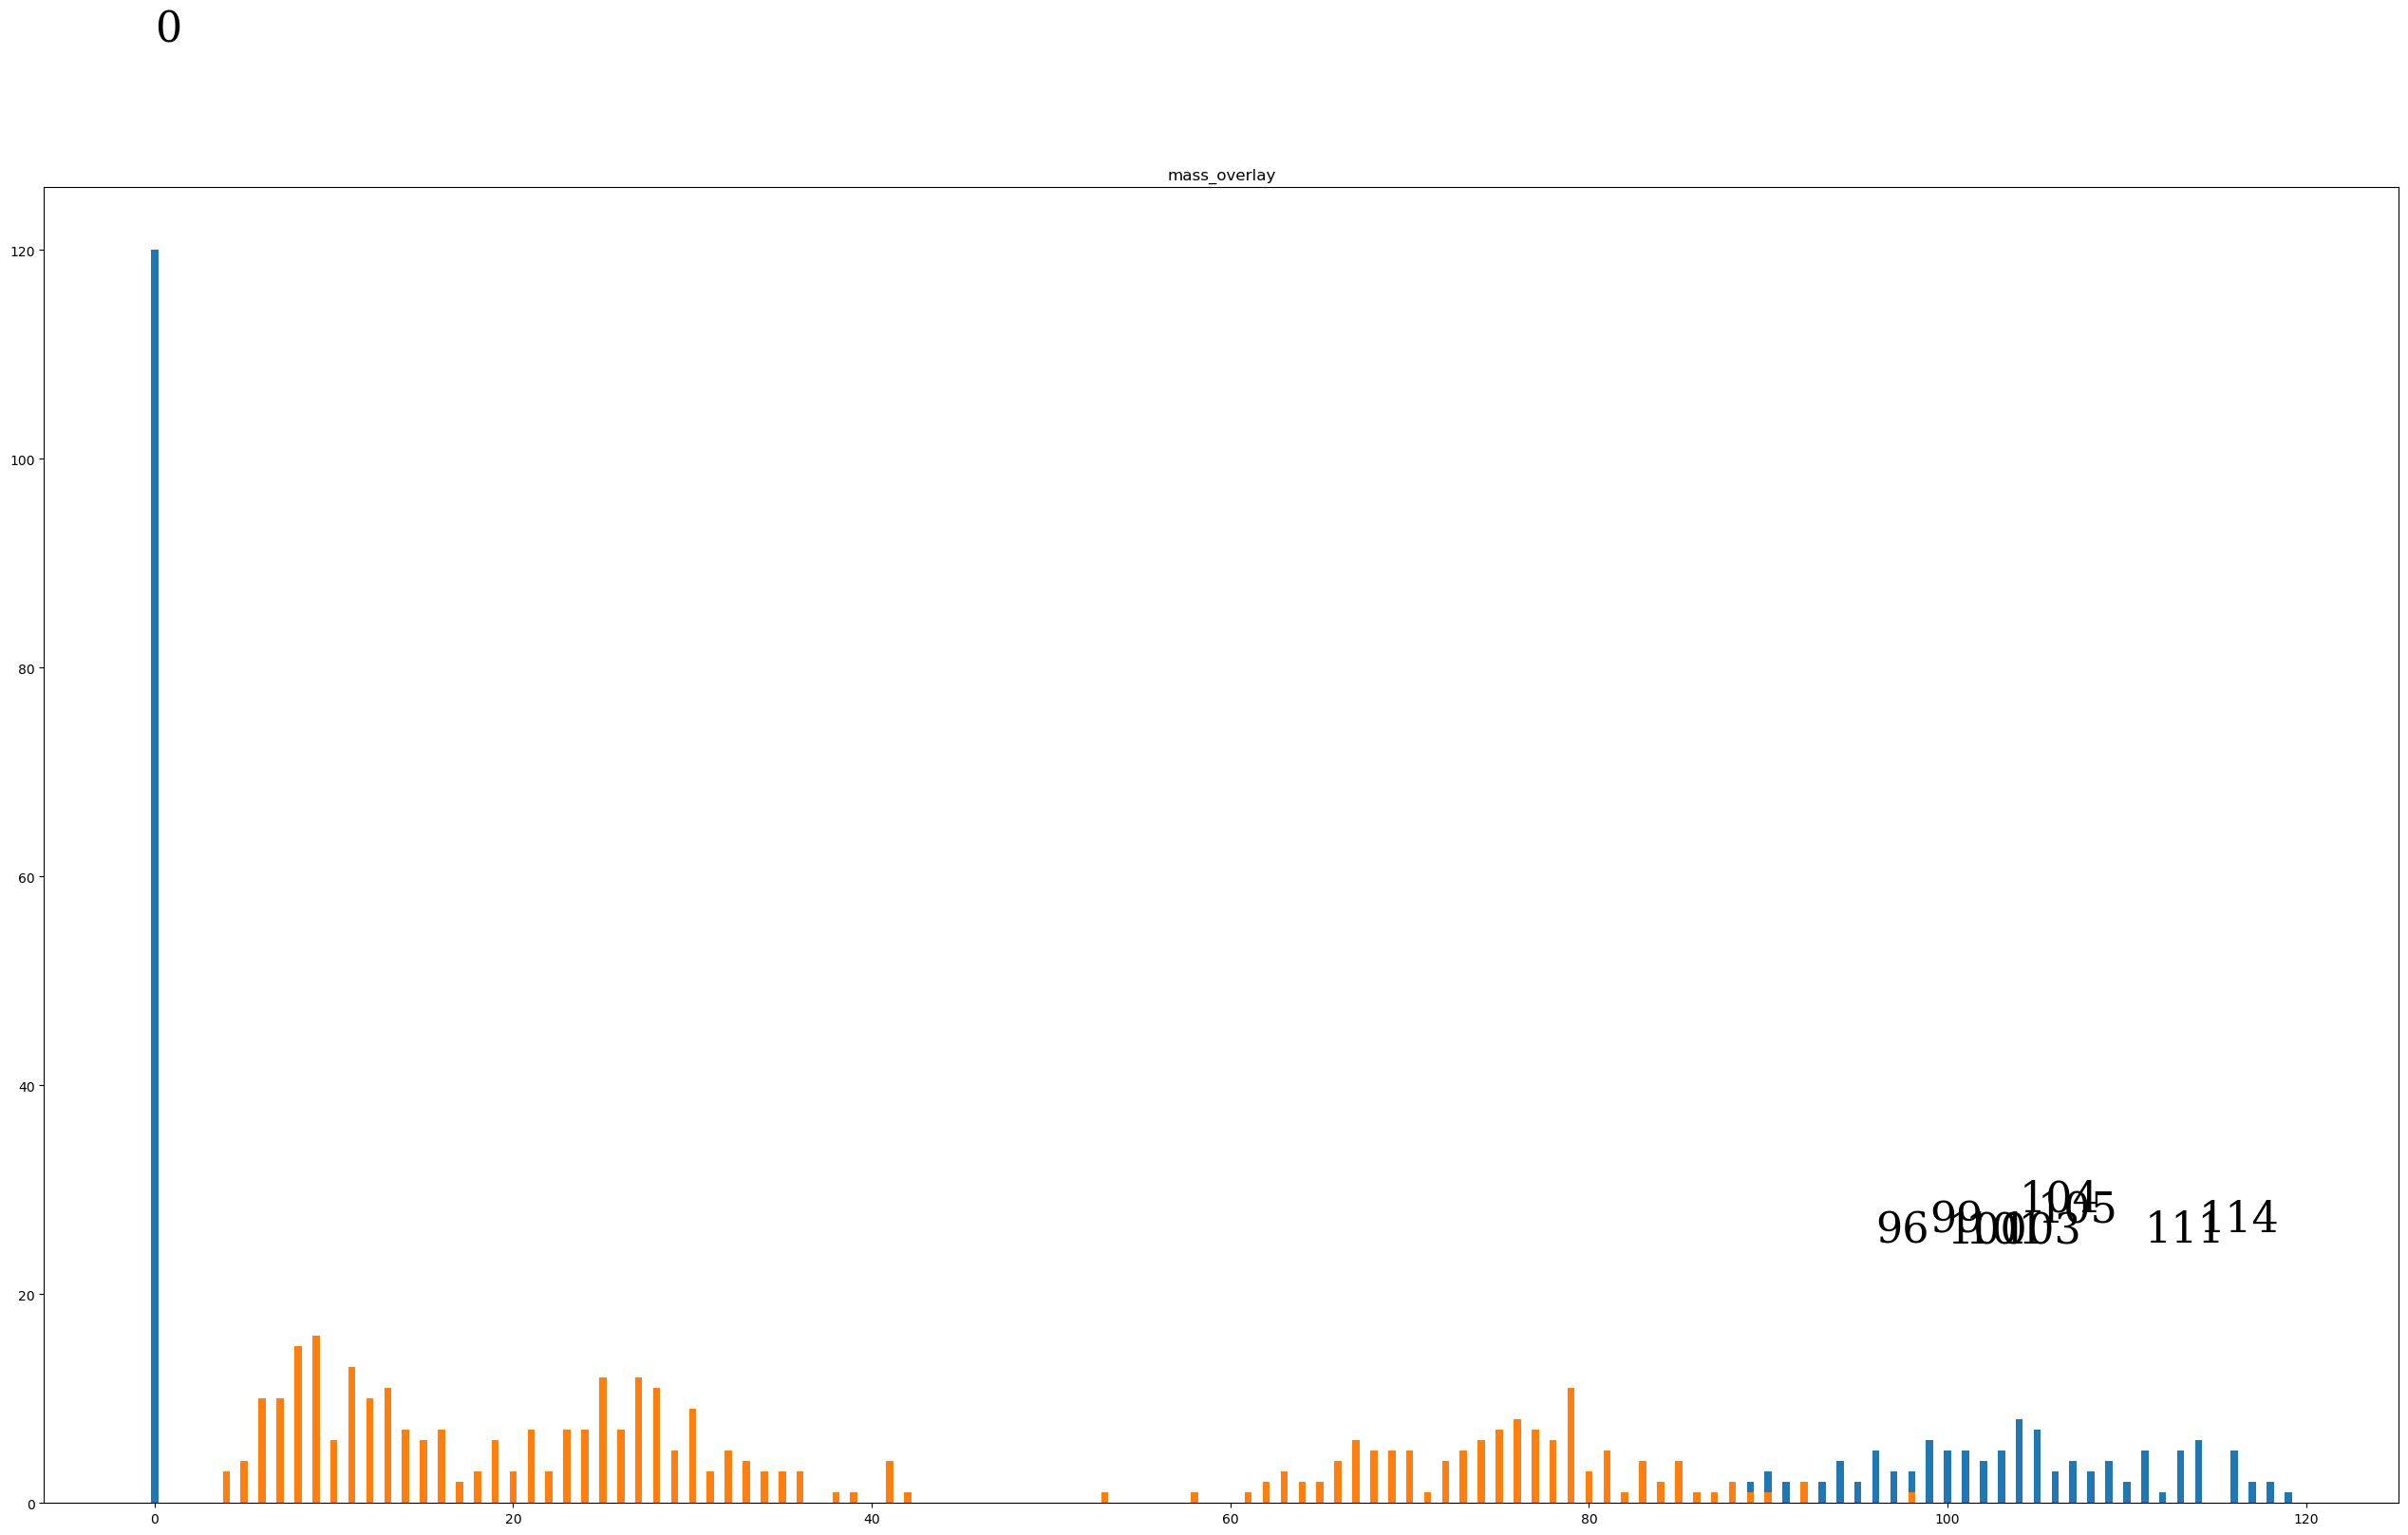

In [27]:
plot.mass_overlay((mass_values, mass_values), (spectrum1, spectrum2))

In [28]:
noisy_chromato_cube_with_two_peaks = np.moveaxis(noisy_chromato_cube_with_two_peaks, -1, 0)
noisy_chromato_cube_with_two_peaks.shape

(120, 2187, 150)

In [29]:
chromato_cube_with_one_peak = np.moveaxis(noisy_chromato_cube_with_one_peak, -1, 0)
chromato_cube_with_one_peak.shape

(120, 2187, 150)

In [30]:
chromato_cube_with_three_peaks = np.moveaxis(noisy_chromato_cube_with_three_peaks, -1, 0)
chromato_cube_with_three_peaks.shape

(120, 2187, 150)

# Spectra similarity

In [31]:
utils.compute_spectra_similarity((mass_values, spectrum1), (mass_values, spectrum2))

2023-05-26 10:54:00,667:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-26 10:54:00,678:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


0.048988589213309966

In [32]:
utils.compute_spectra_similarity((mass_values, spectrum1), (mass_values, spectrum3))

2023-05-26 10:54:04,848:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-26 10:54:04,849:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


0.18777988336739188

Similarity score is 0.47

# Peak detection

In [33]:
u = peak_detection.peak_detection(chromato_obj=(chromato_TIC_two_peaks, time_rn, spectra_obj), spectra=None, chromato_cube=None, seuil=0.1, ABS_THRESHOLDS=None, method='peak_local_max')
u

array([[397,  43]], dtype=int64)

In [34]:
mu_peak_1, mu_peak_2

((400, 40), (395, 45))

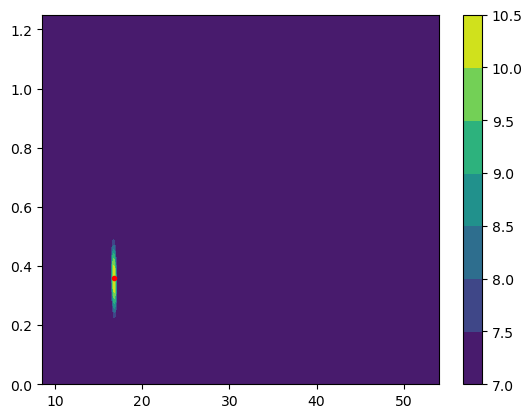

370 10


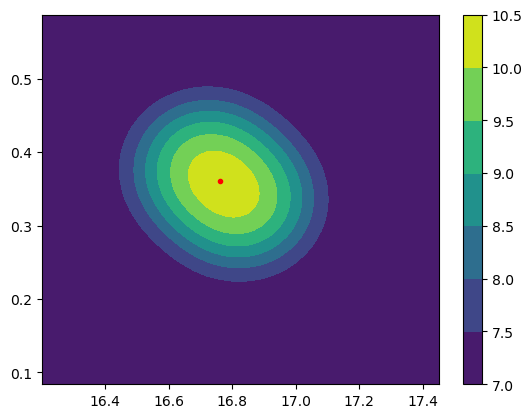

In [35]:
coordinates_in_chromato = projection.matrix_to_chromato(u, time_rn, 1.25, chromato.shape)
plot.visualizer((chromato_TIC_two_peaks, time_rn), log_chromato=True, points=coordinates_in_chromato)
plot.visualizer((chromato_TIC_two_peaks, time_rn), center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, log_chromato=True, points=coordinates_in_chromato)


peak detection with one peak

In [36]:
u_one_peak = peak_detection.peak_detection(chromato_obj=(chromato_TIC_one_peak, time_rn, spectra_obj), spectra=None, chromato_cube=None, seuil=0.1, ABS_THRESHOLDS=None, method='peak_local_max')
u_one_peak

array([[400,  40]], dtype=int64)

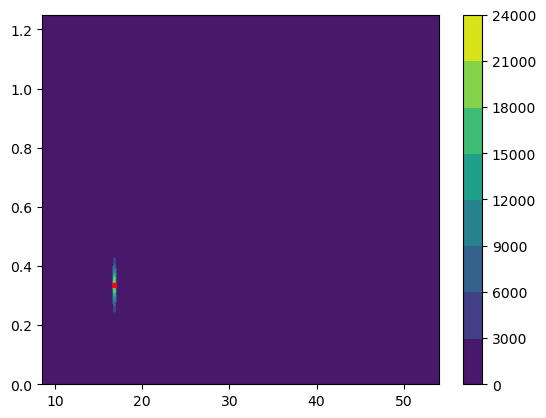

370 10


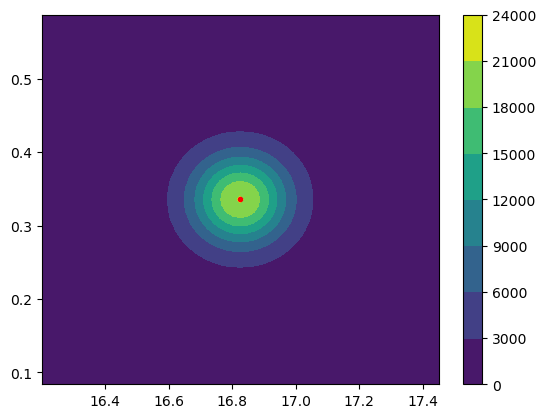

In [37]:
coordinates_in_chromato_one_peak = projection.matrix_to_chromato(u_one_peak, time_rn, 1.25, chromato.shape)
plot.visualizer((chromato_TIC_one_peak, time_rn), log_chromato=False, points=coordinates_in_chromato_one_peak)
plot.visualizer((chromato_TIC_one_peak, time_rn), center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, log_chromato=False, points=coordinates_in_chromato_one_peak)

three peaks

In [38]:
u_three_peak = peak_detection.peak_detection(chromato_obj=(chromato_TIC_three_peaks, time_rn, spectra_obj), spectra=None, chromato_cube=None, seuil=0.1, ABS_THRESHOLDS=None, method='peak_local_max')

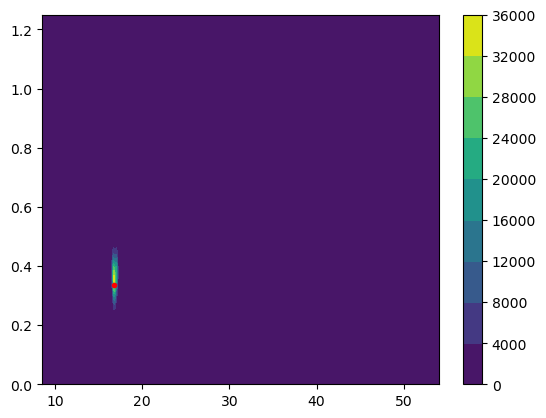

370 10


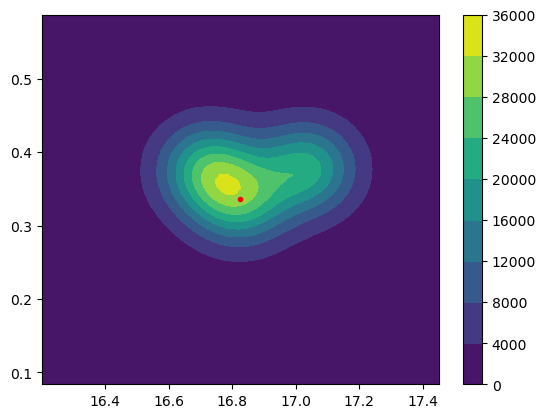

In [39]:
coordinates_in_chromato_three_peak = projection.matrix_to_chromato(u_three_peak, time_rn, 1.25, chromato.shape)
plot.visualizer((chromato_TIC_three_peaks, time_rn), log_chromato=False, points=coordinates_in_chromato_one_peak)
plot.visualizer((chromato_TIC_three_peaks, time_rn), center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, log_chromato=False, points=coordinates_in_chromato_one_peak)

# Search Zone

In [40]:
def tmp(chromato, coordinates, coordinate, threshold=0.25):
    mask = np.zeros(chromato.shape, dtype=bool)
    mask[tuple(coordinates.T)] = True
    markers, _ = ndi.label(mask)
    peak_apex_int = chromato[coordinate[0]][coordinate[1]]
    img = np.where(chromato < threshold * peak_apex_int, 0, 1)
    labels = watershed(-chromato, markers, mask=img)
    coordinate_label = labels[coordinate[0]][coordinate[1]]
    blob = np.where(labels != coordinate_label, 0, 1)
    cds = []
    for cd in np.argwhere(blob == 1):
        cds.append([cd[0], cd[1]])
    return cds

In [41]:
def compute_spectra_array(cds, chromato_cube):
    spc=[]
    for i,cd in enumerate(cds):
        spc.append(mass_spec.read_spectrum_from_chromato_cube(cd, chromato_cube=chromato_cube))
    return np.array(spc)

In [42]:
#search zone
cds = np.array(tmp(chromato_TIC_two_peaks, u, u[0], threshold=0.3))
#spectra in search zone
spc=compute_spectra_array(cds, noisy_chromato_cube_with_two_peaks)
cds.shape, spc.shape

((266, 2), (266, 120))

In [43]:
#search zone one peak
cds_one_peak = np.array(tmp(chromato_TIC_one_peak, u_one_peak, u_one_peak[0], threshold=0.3))
#spectra in search zone one peak
spc_one_peak=compute_spectra_array(cds_one_peak, chromato_cube_with_one_peak)
cds_one_peak.shape, spc_one_peak.shape

((213, 2), (213, 120))

In [44]:
#search zone one peak
cds_three_peak = np.array(tmp(chromato_TIC_three_peaks, u_three_peak, u_three_peak[0], threshold=0.3))
#spectra in search zone one peak
spc_three_peak=compute_spectra_array(cds_three_peak, chromato_cube_with_three_peaks)
cds_three_peak.shape, spc_three_peak.shape

((406, 2), (406, 120))

## Blob

In [45]:
blob = integration.peak_pool_similarity_check(chromato_TIC_two_peaks, u, u[0], noisy_chromato_cube_with_two_peaks, threshold=0.1, plot_labels=True, similarity_threshold=0.01)

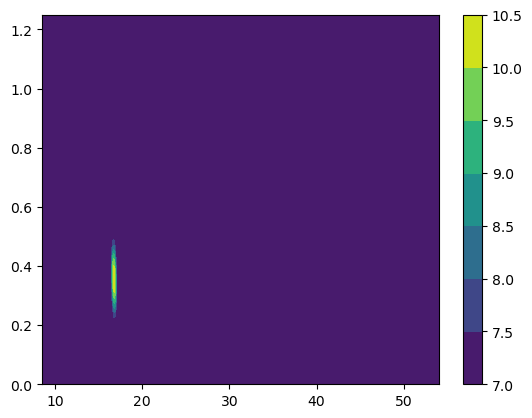

c:\Users\33631\Desktop\stage\pic\plot.py:354: RuntimeWarning: divide by zero encountered in log
  chromato = np.log(chromato)


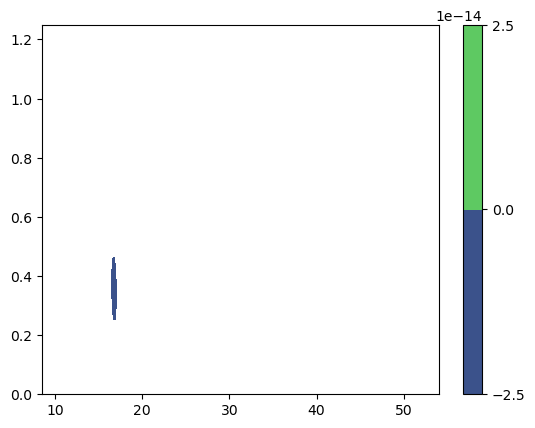

In [46]:
plot.visualizer((chromato_TIC_two_peaks, time_rn))
plot.visualizer((blob, time_rn))

In [47]:
ctr = integration.get_contour(blob, chromato_TIC_two_peaks, time_rn)

370 10


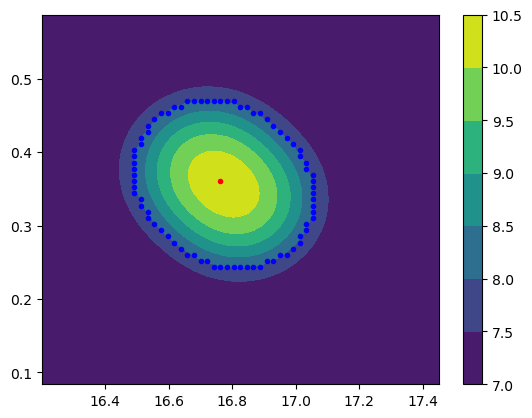

In [48]:
plot.visualizer((chromato_TIC_two_peaks, time_rn), contour=ctr, points=projection.matrix_to_chromato(u, time_rn, 1.25, chromato.shape), center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30)

Ca se sépare mais il faut un score hyper elevé alors que le score entre les spectres est de 0.0

## DBSCAN

In [49]:
sklearn.metrics.pairwise_distances(X=[spectrum1], Y=[spectrum2], metric='cosine')

array([[0.99486777]])

In [50]:
def similarity_cluestering(chromato_cube, coordinates, ref_point, similarity_threshold=0.01):
    intensity_values_list = []
    ref_point_index = 0

    for i, coordinate in enumerate(coordinates):
        if (coordinate[0]==ref_point[0] and coordinate[1]==ref_point[1]):
            ref_point_index = i
        int_values = mass_spec.read_spectrum_from_chromato_cube(coordinate, chromato_cube=chromato_cube)
        intensity_values_list.append(int_values)
    intensity_values_list = np.array(intensity_values_list)
    clustering = DBSCAN(eps=similarity_threshold, min_samples=1, metric='cosine').fit(intensity_values_list)
    ref_label = (clustering.labels_[ref_point_index])
    res = []
    print(clustering.labels_)
    for i, coordinate in enumerate(coordinates):
        if (clustering.labels_[i] == ref_label):
            res.append(coordinate)
    return np.array(res)

In [51]:
label_m=similarity_cluestering(noisy_chromato_cube_with_two_peaks, coordinates=cds, ref_point=u[0], similarity_threshold=0.01)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]


Les spectres se mélangent progressivement donc DBSCAN ne semble pas adapté car il calcule les distances de proche en proche

## Dist

In [52]:
def compute_pairwise_spectra_distance(cds, spc):
    pairwise_spectra_distance = np.zeros((len(cds), len(cds)))
    for i, cd1 in enumerate(cds):
        i1 = spc[i]
        for j, cd2 in enumerate(cds):
            if (j > i):
                continue
            i2 =spc[j]
            d=sklearn.metrics.pairwise_distances(X=[i1], Y=[i2], metric='cosine')
            pairwise_spectra_distance[i,j]=d
    return pairwise_spectra_distance

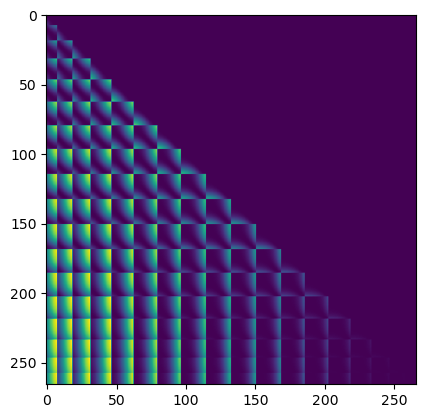

In [53]:
pairwise_spectra_distance=compute_pairwise_spectra_distance(cds, spc)
plt.imshow(pairwise_spectra_distance)

In [54]:
sorted_list = np.dstack(np.unravel_index(np.argsort((-pairwise_spectra_distance.ravel())), pairwise_spectra_distance.shape))[0]

In [55]:
stacked_pair=[]
for cd in sorted_list[:]:
    if (pairwise_spectra_distance[cd[0]][cd[1]] > 0.15):
        stacked_pair.append(cds[cd[0]])
        stacked_pair.append(cds[cd[1]])
stacked_pair=np.array(stacked_pair)
len(stacked_pair)

24522

In [56]:
c_in_chromato=projection.matrix_to_chromato(stacked_pair, time_rn, 1.25, chromato.shape)

In [57]:
#dist min, dist max
pairwise_spectra_distance[sorted_list[0][0], sorted_list[0][1]], pairwise_spectra_distance[sorted_list[-1][0], sorted_list[-1][1]]

(0.7509203871863761, 0.0)

370 10


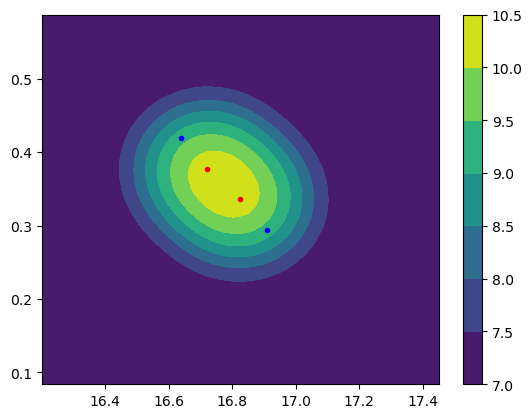

In [58]:
plot.visualizer((chromato_TIC_two_peaks, time_rn), contour=c_in_chromato[:2], points=projection.matrix_to_chromato(np.array([mu_peak_1, mu_peak_2]), time_rn, 1.25, chromato.shape),center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, log_chromato=True)

Distance with one peak

In [59]:
cds_one_peak.shape, spc_one_peak.shape

((213, 2), (213, 120))

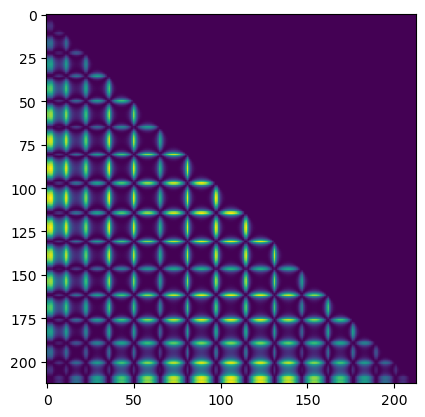

In [60]:
pairwise_spectra_distance_one_peak=compute_pairwise_spectra_distance(cds_one_peak, spc_one_peak)
plt.imshow(pairwise_spectra_distance_one_peak)

In [61]:
sorted_list_one_peak = np.dstack(np.unravel_index(np.argsort((-pairwise_spectra_distance_one_peak.ravel())), pairwise_spectra_distance_one_peak.shape))[0]

In [62]:
pairwise_spectra_distance_one_peak[sorted_list_one_peak[0][0], sorted_list_one_peak[0][1]], pairwise_spectra_distance_one_peak[sorted_list_one_peak[-1][0], sorted_list_one_peak[-1][1]]

(0.00038874952397593976, 0.0)

Tous les spectres sont très similaires quand il y a un seul et même composé, ce qui n'est pas le cas quand il y en a plusieurs (dst_max = 0.78)

## Kmeans

In [63]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(spc)

In [64]:
(kmeans.cluster_centers_)

array([[6839.23687378,   10.0296792 ,   10.02802429,    9.97472943,
          65.69631543,   84.25248449,  195.54347131,  195.59529568,
         288.3378165 ,  306.90923049,  121.37124882,  251.17838183,
         195.58763239,  214.05861852,  139.87691454,  121.31202313,
         139.90860653,   47.128657  ,   65.68894272,  121.3273785 ,
          65.70057897,  139.86877426,   65.70623826,  139.89706436,
         139.89312959,  232.66956249,  139.92095555,  232.67460912,
         214.13150508,  102.80045597,  177.02326599,   65.72000213,
         102.77365147,   84.26496726,   65.67847242,   65.65737071,
          65.65139606,   10.02211174,   28.57686936,   28.52362399,
          10.0304513 ,   84.2024181 ,   28.56122594,    9.97787398,
           9.98648641,   10.0217394 ,   10.00359072,   10.0267358 ,
           9.94344642,   10.0143459 ,   10.01842545,    9.98639116,
           9.94795289,   28.50592417,    9.97449553,   10.00711719,
           9.96942837,   10.01657154,   28.58737

In [65]:
for i, cd in enumerate(cds):
    if (cd[0] == mu_peak_1[0] and cd[1] == mu_peak_1[1]):
        print("index peak 1", i)
    if (cd[0] == mu_peak_2[0] and cd[1] == mu_peak_2[1]):
        print("index peak 2", i)

index peak 2 90
index peak 1 175


In [66]:
kmeans.predict([spc[97], spc[180]])

array([1, 0])

In [67]:
pred=kmeans.predict(spc)

370 10


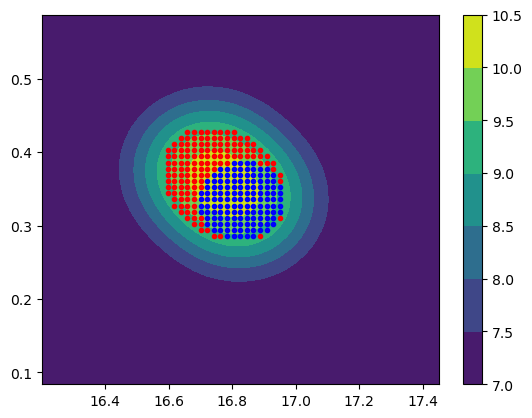

In [68]:
plot.visualizer((chromato_TIC_two_peaks, time_rn), contour=projection.matrix_to_chromato(np.array(cds[np.argwhere(pred == 0).reshape(-1)]
), time_rn, 1.25, chromato.shape), points=projection.matrix_to_chromato(np.array(cds[np.argwhere(pred == 1).reshape(-1)]
), time_rn, 1.25, chromato.shape),center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, log_chromato=True)

370 10


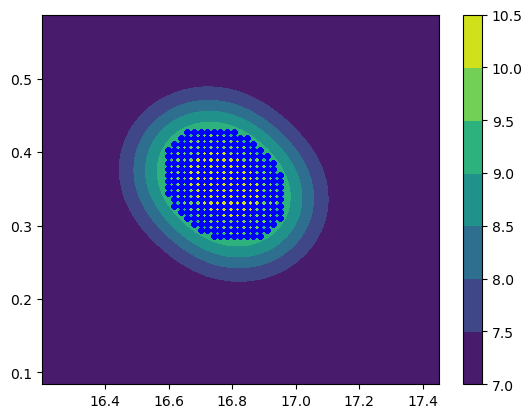

In [69]:
plot.visualizer((chromato_TIC_two_peaks, time_rn), contour=c_in_chromato[:], points=projection.matrix_to_chromato(np.array(u), time_rn, 1.25, chromato.shape),center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, log_chromato=True)

In [70]:
intensity_center = mass_spec.read_spectrum_from_chromato_cube(u[0], noisy_chromato_cube_with_two_peaks)

## ACP

In [71]:
from sklearn.decomposition import PCA
# X représente les données spectrales superposées (chaque ligne représente un spectre)
# Effectue l'ACP en réduisant la dimension à k composantes principales
def perform_pca(X, k):
    pca = PCA(n_components=k)
    X_pca = pca.fit_transform(X)
    return X_pca,pca

# Exemple d'utilisation
#X_superpose = intensity_center
k = 2  # Nombre de composantes principales à extraire
X_pca,pca= perform_pca(spc, k)

In [72]:
pca.explained_variance_ratio_

array([0.93242678, 0.06757186])

In [73]:
pca.singular_values_

array([46343.6354169, 12475.7215617])

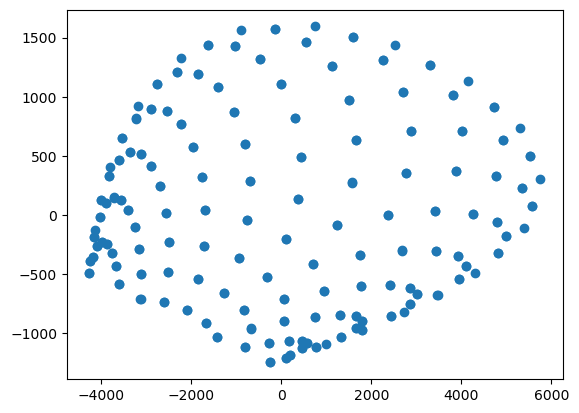

In [74]:
plt.scatter(X_pca[:,0], X_pca[:,1])

In [75]:
np.sort(np.abs(pca.components_[0]))[-10:]

array([0.04079397, 0.04079719, 0.04079827, 0.04079888, 0.04080026,
       0.04894558, 0.04895743, 0.05710194, 0.06526536, 0.97903757])

In [76]:
n_pcs= pca.components_.shape[0]
most_important = [np.argsort(np.abs(pca.components_[i]))[-10:] for i in range(n_pcs)]

In [77]:
most_important

[array([116, 100, 113,  96, 111, 114,  99, 105, 104,   0], dtype=int64),
 array([12,  7, 13, 28, 79, 27, 25, 11,  8,  9], dtype=int64)]

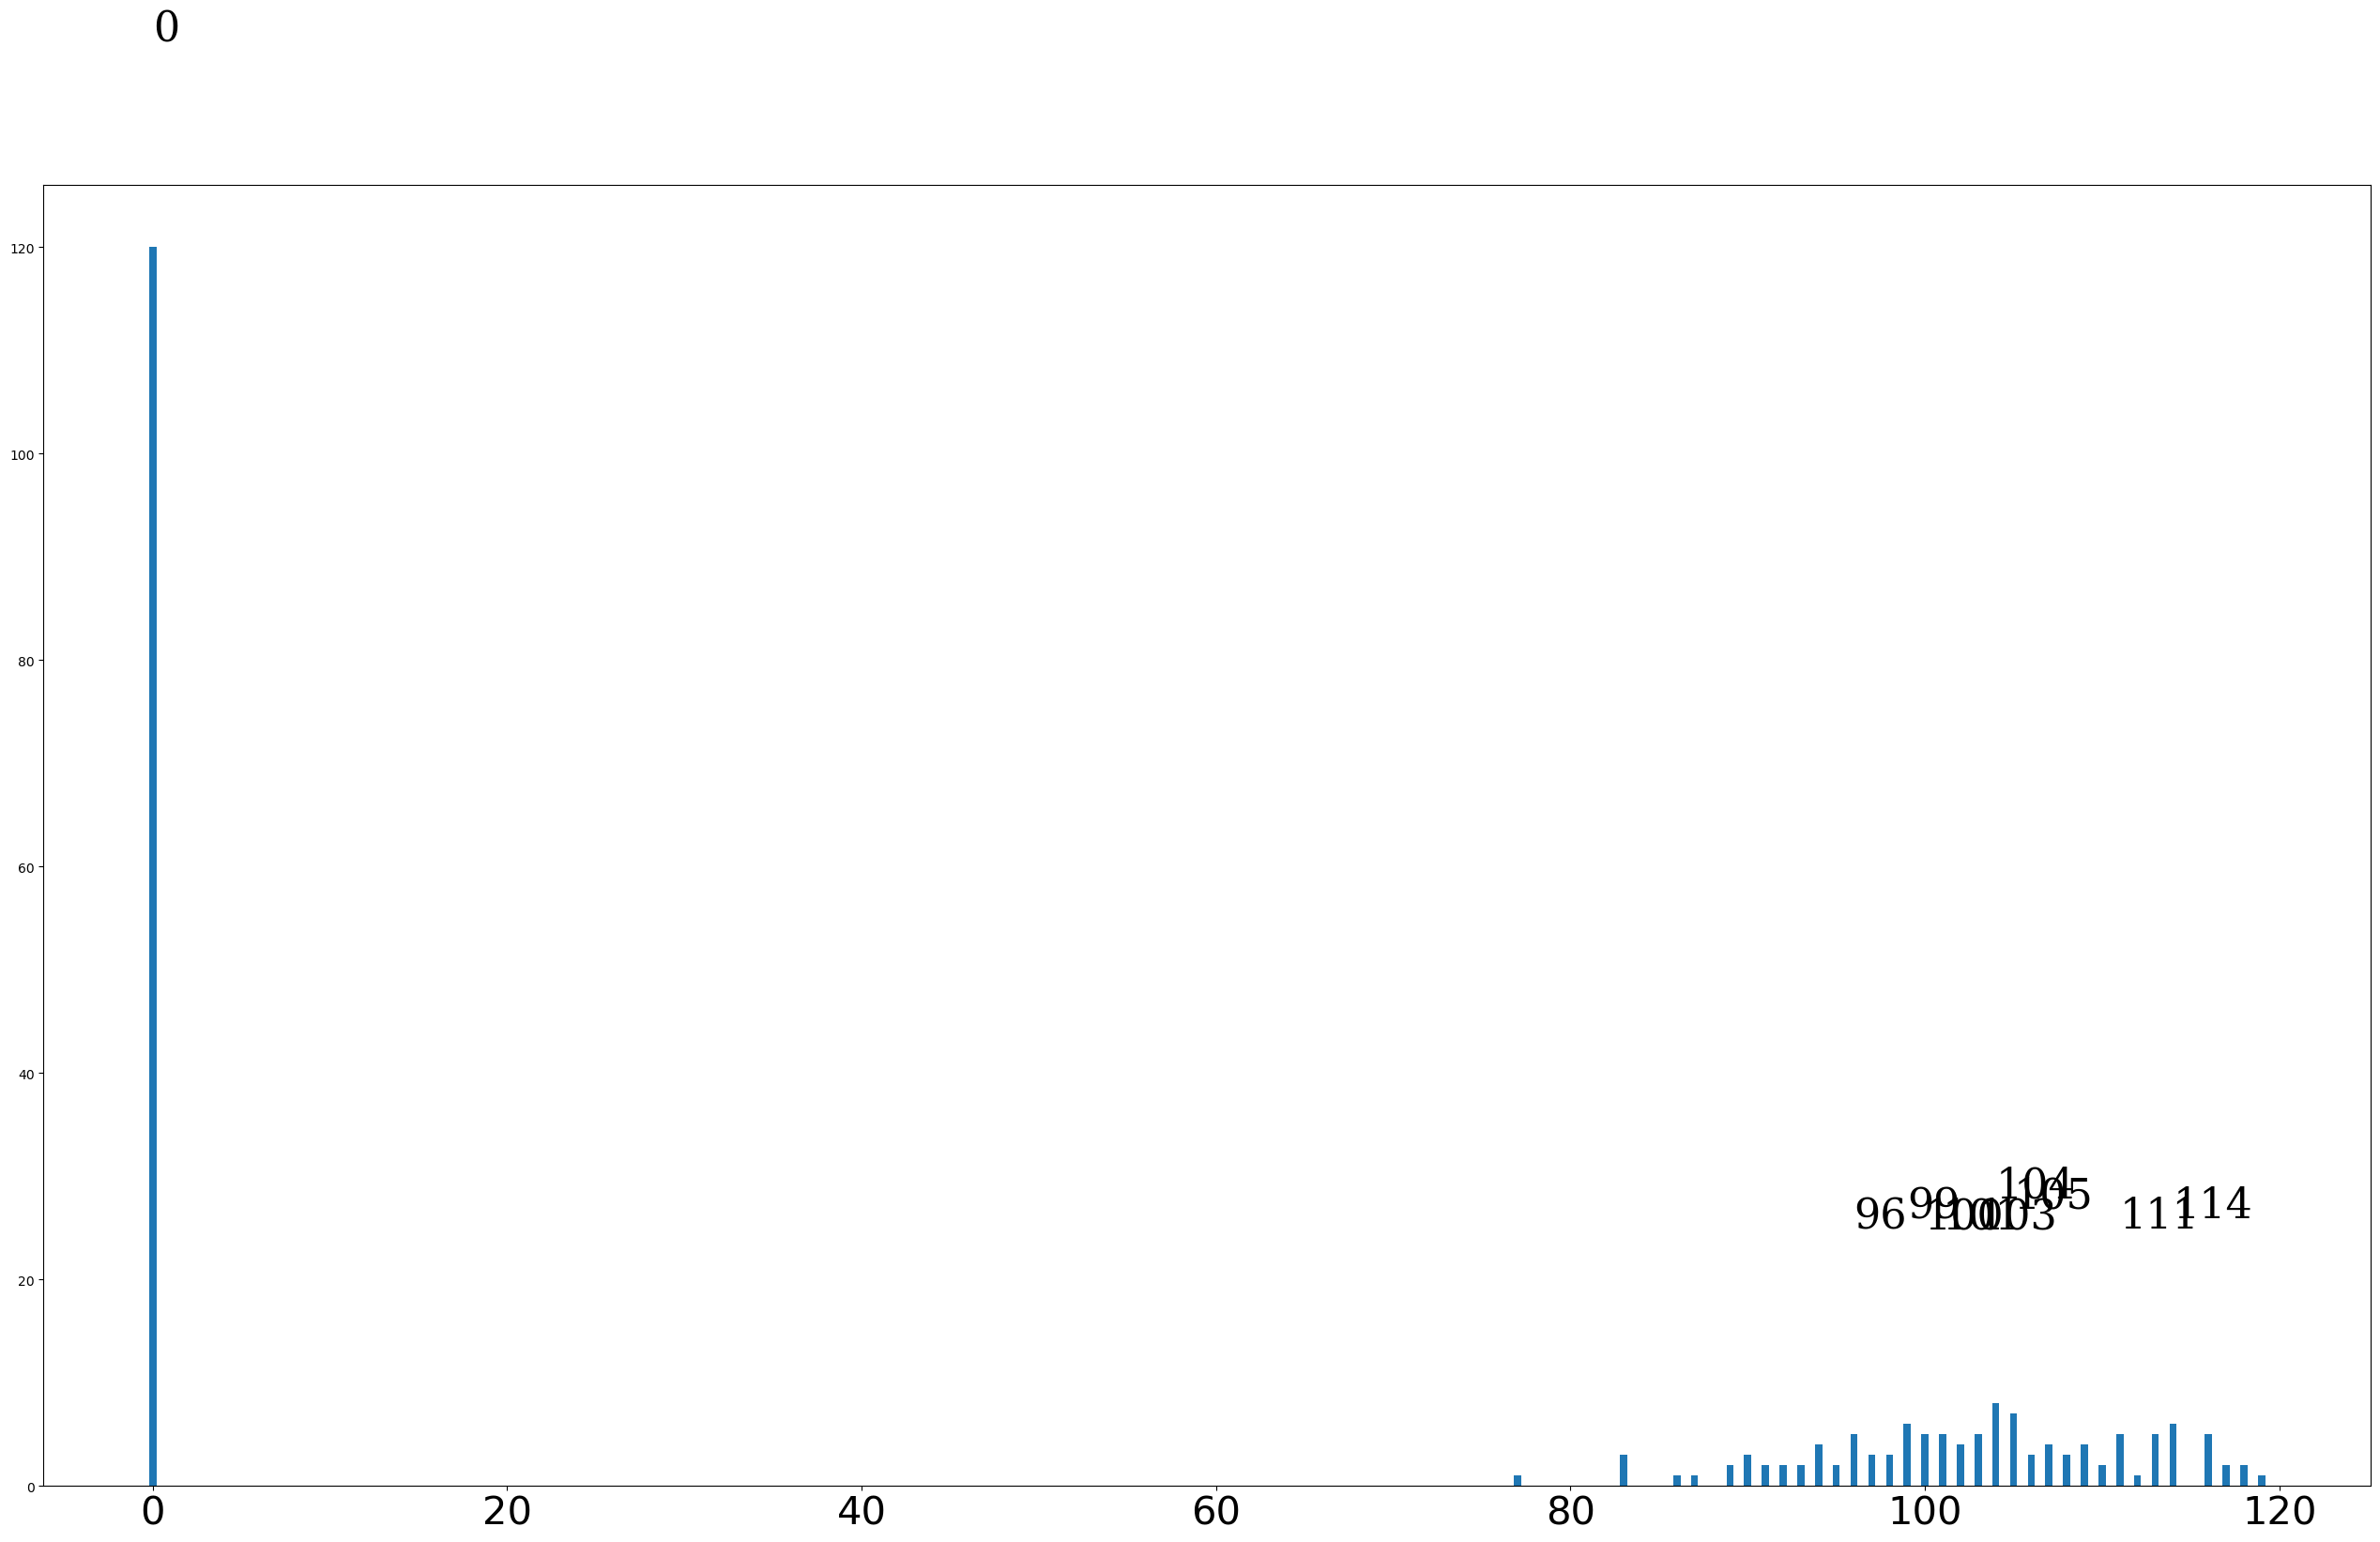

In [78]:
plot.plot_mass(mass_values,spectrum1)

In [79]:
most_important

[array([116, 100, 113,  96, 111, 114,  99, 105, 104,   0], dtype=int64),
 array([12,  7, 13, 28, 79, 27, 25, 11,  8,  9], dtype=int64)]

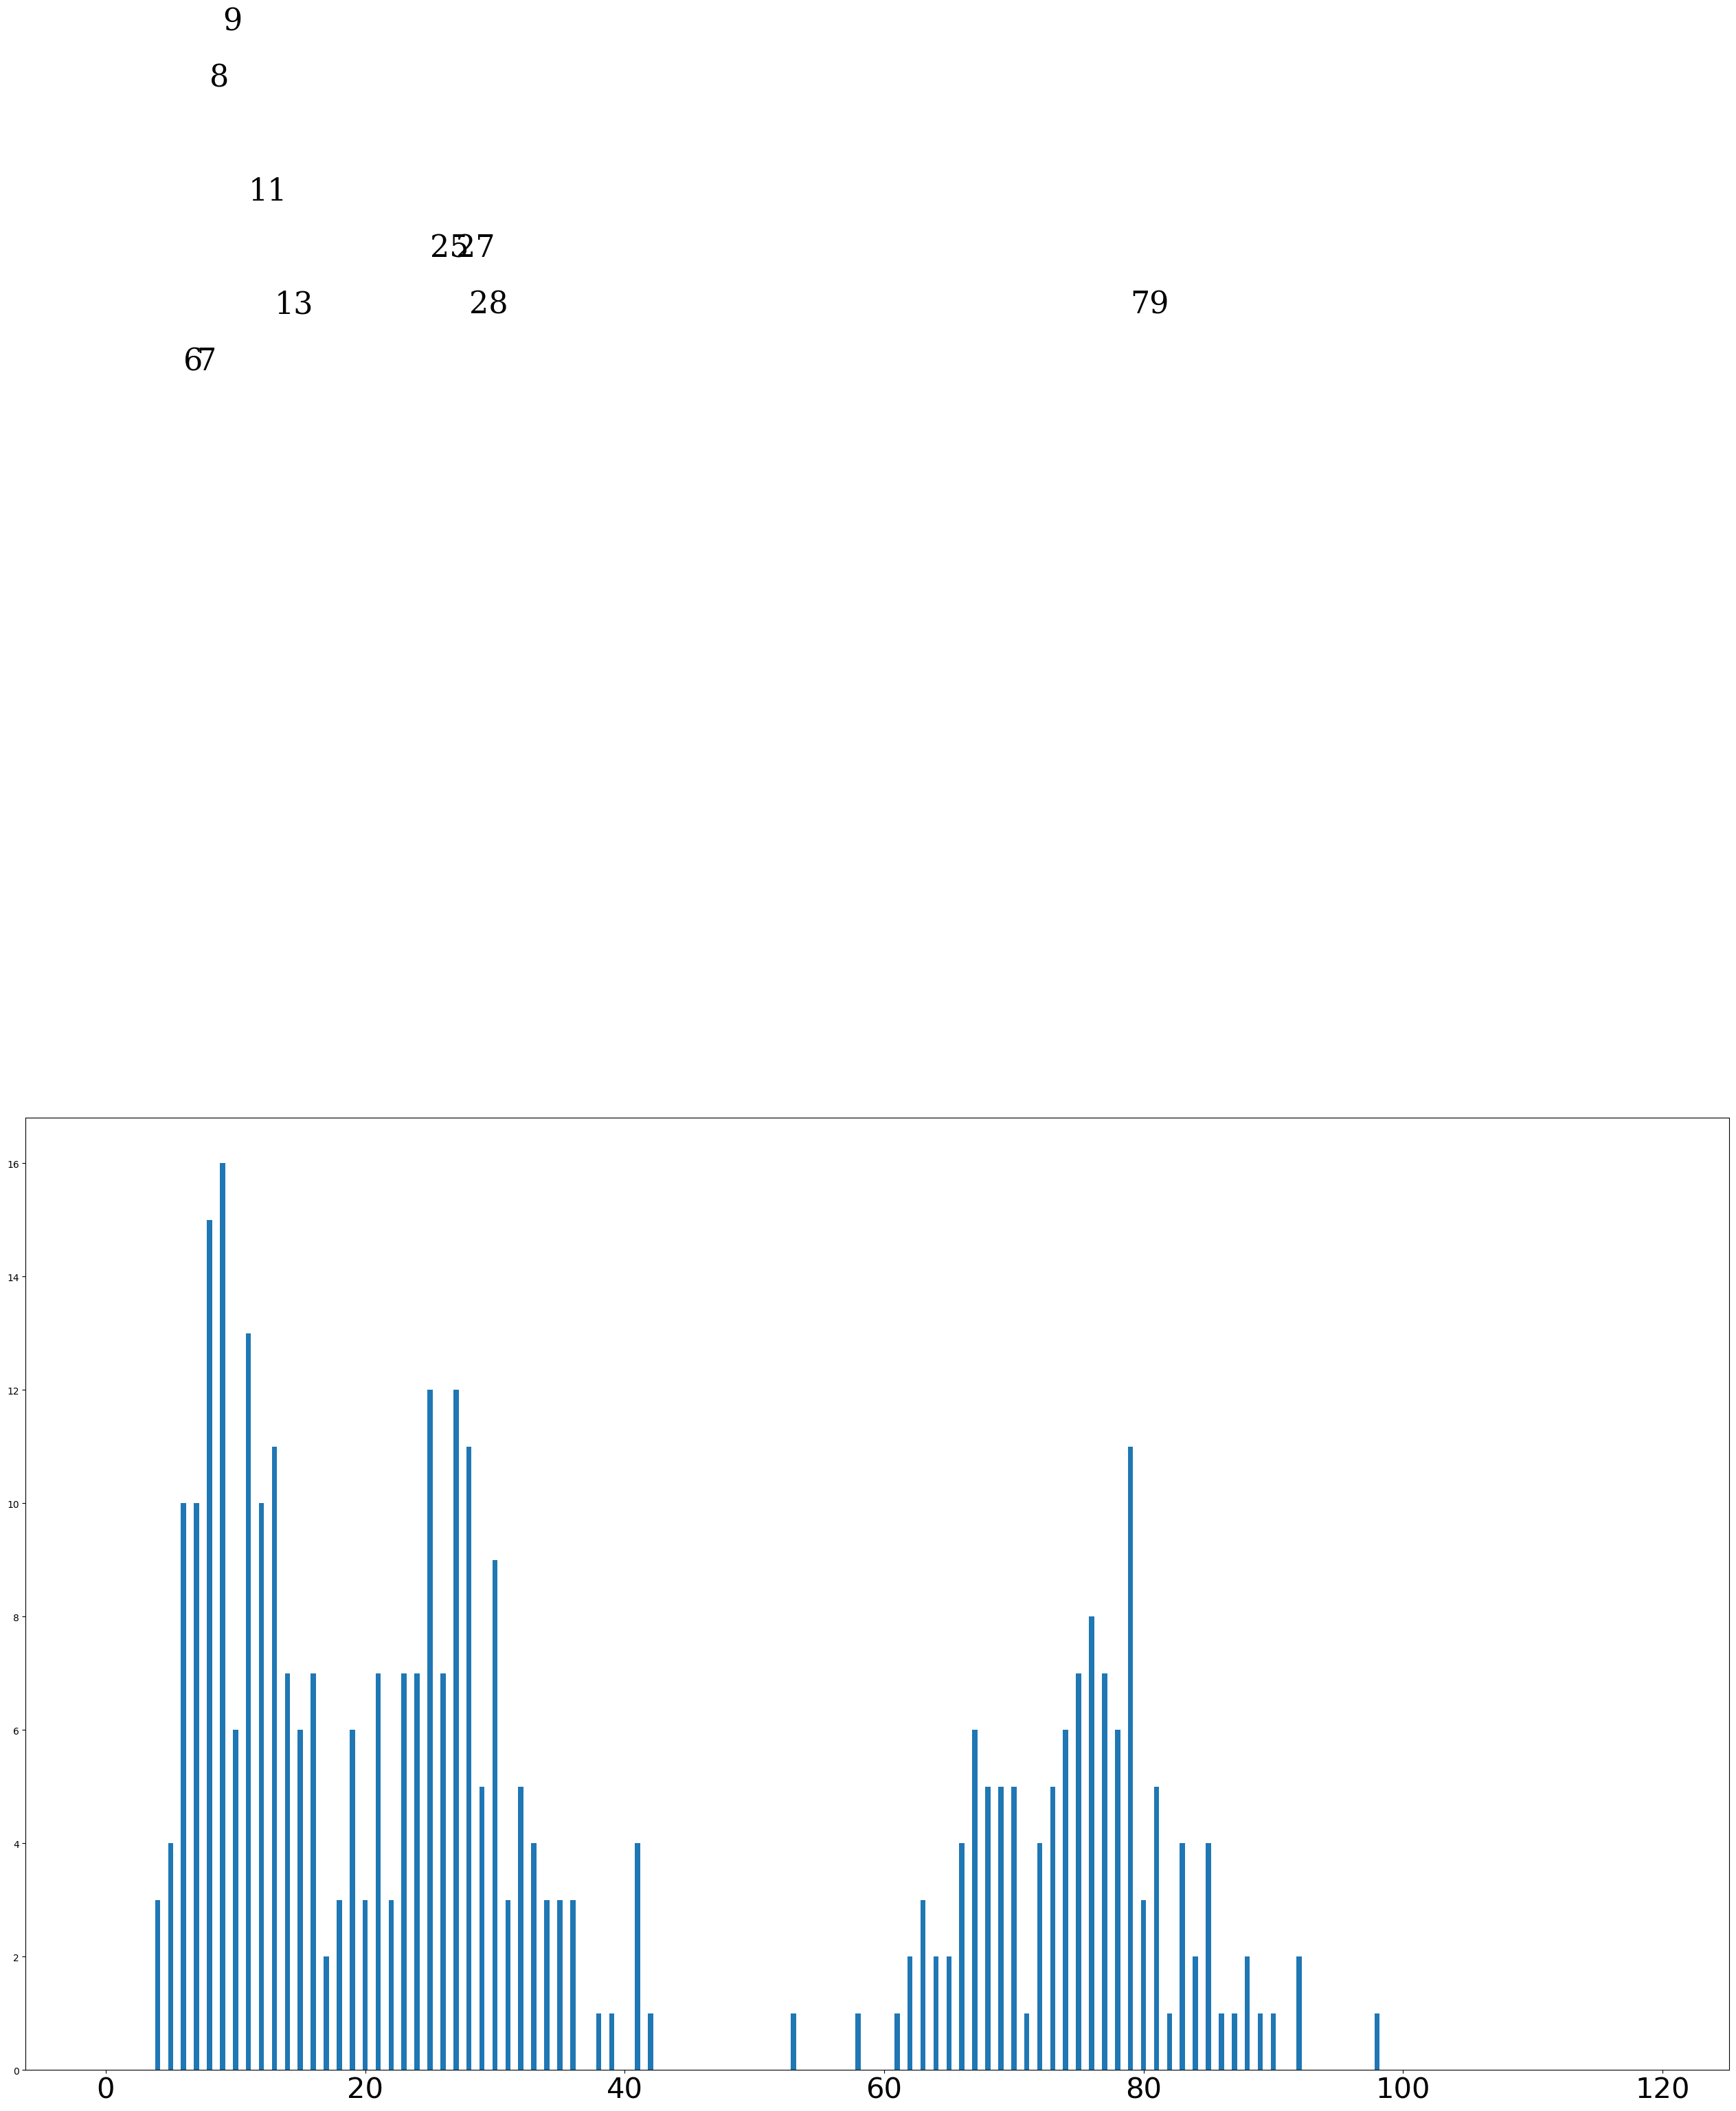

In [80]:
plot.plot_mass(mass_values,spectrum2)

## GaussMix

In [81]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=2, random_state=0).fit(cds)

In [82]:
mu_peak_1, mu_peak_2

((400, 40), (395, 45))

In [83]:
gm.means_

array([[400.27049633,  39.47808836],
       [394.72950367,  45.52191164]])

In [84]:
gaussian_peak_centers=np.around(gm.means_,0).astype(int)

In [85]:
utils.compute_spectra_similarity((mass_values, mass_spec.read_spectrum_from_chromato_cube(gaussian_peak_centers[0], noisy_chromato_cube_with_two_peaks)), (mass_values,mass_spec.read_spectrum_from_chromato_cube(gaussian_peak_centers[1], noisy_chromato_cube_with_two_peaks)))

2023-05-26 10:54:30,062:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-26 10:54:30,063:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


0.6605678372226388

In [86]:
utils.compute_spectra_similarity((mass_values, mass_spec.read_spectrum_from_chromato_cube(mu_peak_1, noisy_chromato_cube_with_two_peaks)), (mass_values,mass_spec.read_spectrum_from_chromato_cube(mu_peak_2, noisy_chromato_cube_with_two_peaks)))

2023-05-26 10:54:30,311:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.
2023-05-26 10:54:30,312:WARNING:matchms:add_precursor_mz:No precursor_mz found in metadata.


0.7408747091038239

370 10


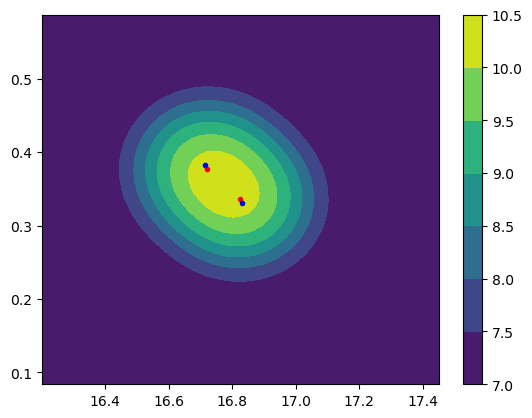

In [87]:
plot.visualizer((chromato_TIC_two_peaks, time_rn), contour=projection.matrix_to_chromato(gm.means_, time_rn, 1.25, chromato.shape), points=projection.matrix_to_chromato(np.array([mu_peak_1, mu_peak_2]), time_rn, 1.25, chromato.shape),center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, log_chromato=True)

370 10


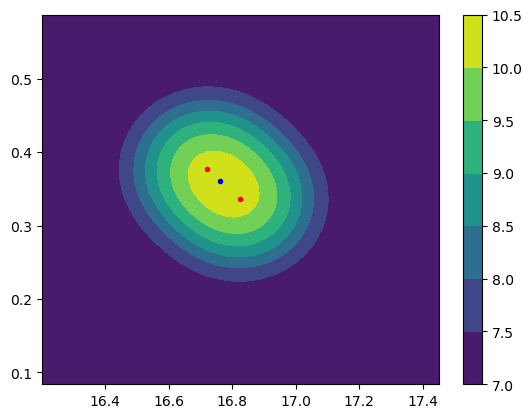

In [88]:
plot.visualizer((chromato_TIC_two_peaks, time_rn), contour=projection.matrix_to_chromato(u,time_rn, 1.25, chromato.shape), points=projection.matrix_to_chromato(np.array([mu_peak_1, mu_peak_2]), time_rn, 1.25, chromato.shape),center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, log_chromato=True)

In [89]:
#nbcomp estim
def estimate_num_components(X, max_components=5):
    n_components_range = range(1, max_components+1)
    bics = []
    
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components)
        gmm.fit(X)
        bic = gmm.bic(X)
        bics.append(bic)
    
    optimal_num_components = np.argmin(bics) + 1
    print(bics)
    return optimal_num_components

In [90]:
optimal_num_components = estimate_num_components(cds, max_components=5)
optimal_num_components

[3161.1215936114877, 3173.39797156018, 3166.1455748811754, 3190.1430335042232, 3214.356025258924]


1

three peaks

In [91]:
optimal_num_components = estimate_num_components(cds_three_peak, max_components=5)
optimal_num_components

[5176.105450349491, 5150.782709871607, 5145.290101730384, 5161.209009350514, 5182.192240344438]


3

In [92]:
gm3 = GaussianMixture(n_components=3, random_state=0).fit(cds_three_peak)

In [93]:
gaussian_peak_centers_three_peaks=np.around(gm3.means_,0).astype(int)

370 10


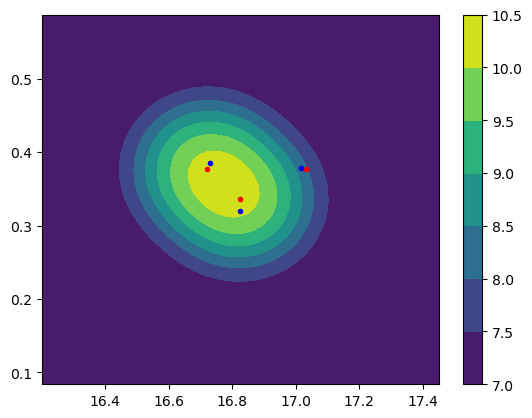

In [94]:
plot.visualizer((chromato_TIC_two_peaks, time_rn), contour=projection.matrix_to_chromato(gm3.means_, time_rn, 1.25, chromato.shape), points=projection.matrix_to_chromato(np.array([mu_peak_1, mu_peak_2, mu_peak_3]), time_rn, 1.25, chromato.shape),center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, log_chromato=True)

In [95]:
gm3.covariances_

array([[[22.47626137,  0.16299656],
        [ 0.16299656,  6.17818917]],

       [[16.09273946, -0.65226672],
        [-0.65226672, 12.48158578]],

       [[16.04078038,  3.16177192],
        [ 3.16177192, 10.29295748]]])

## Find peaks mass per mass and no cluster

In [96]:
#u_mpm = peak_detection.peak_detection(chromato_obj=(new_chroma_with_2_peaks, time_rn, spectra_obj), spectra=None, chromato_cube=noisy_chromato_cube_with_two_peaks, seuil=0.1, ABS_THRESHOLDS=0.7, method='peak_local_max', mode='mass_per_mass', cluster=False)
#plot.visualizer((chromato_TIC_two_peaks, time_rn), points=projection.matrix_to_chromato(np.array(u_mpm), time_rn, 1.25, chromato.shape),center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, log_chromato=True)

Ca semble difficile de séparer les peaks comme ça

In [97]:
#u_mpm_clst = peak_detection.peak_detection(chromato_obj=(new_chroma_with_2_peaks, time_rn, spectra_obj), spectra=None, chromato_cube=noisy_chromato_cube_with_two_peaks, seuil=0.1, ABS_THRESHOLDS=0.1, method='peak_local_max', mode='mass_per_mass', cluster=True)
#plot.visualizer((chromato_TIC_two_peaks, time_rn), points=projection.matrix_to_chromato(np.array(u_mpm_clst), time_rn, 1.25, chromato.shape),center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, log_chromato=True)

## AgglomerativeClustering

In [98]:
clustering = AgglomerativeClustering(n_clusters=None, linkage='complete', affinity='cosine', distance_threshold=0.2).fit(spc)

In [99]:
clustering = AgglomerativeClustering(n_clusters=2, linkage='complete', affinity='cosine').fit(spc)

In [100]:
clustering.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

370 10


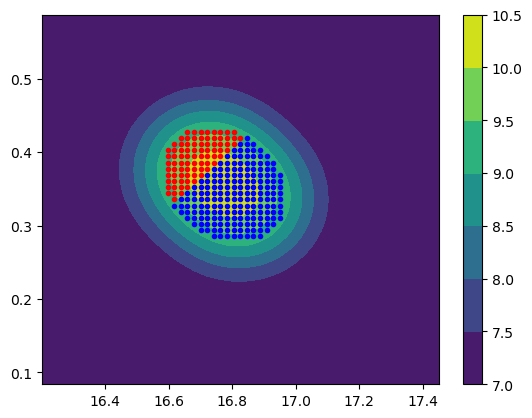

In [101]:
plot.visualizer((chromato_TIC_two_peaks, time_rn), contour=projection.matrix_to_chromato(np.array(cds[np.argwhere(clustering.labels_ == 1).reshape(-1)]
), time_rn, 1.25, chromato.shape), points=projection.matrix_to_chromato(np.array(cds[np.argwhere(clustering.labels_ == 0).reshape(-1)]
), time_rn, 1.25, chromato.shape),center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, log_chromato=True)

370 10


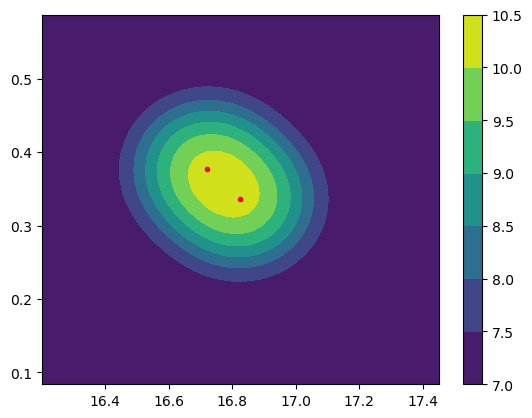

In [102]:
plot.visualizer((chromato_TIC_two_peaks, time_rn), points=projection.matrix_to_chromato(np.array([mu_peak_1, mu_peak_2]), time_rn, 1.25, chromato.shape),center_pt=[400,40], center_pt_window_1=30,center_pt_window_2=30, log_chromato=True)

## Birch

In [103]:
from sklearn.cluster import Birch

In [104]:
brc = Birch(n_clusters=None)

In [105]:
brc.fit(spc)

Birch(n_clusters=None)

In [106]:
brc.labels_

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  49,  74,  50,  51,  52,  53,
        54,  20,  21,  22,  23,  24,  75,  76,  77,  78,  79,  80,  81,
        82,  55,  56,  25,  26,  27,  28,  29, 107, 108, 109, 110, 111,
        83,  84,  85,  86,  87,  57,  58,  59,  30,  31,  32, 112, 113,
       114, 115, 195, 196, 197, 116,  88,  89,  90,  91,  60,  61,  33,
        34,  35, 117, 118, 198, 199, 237, 238, 239, 240, 241,  92,  93,
        94,  62,  63,  64,  36,  37, 119, 120, 200, 201, 242, 243, 244,
       245, 246, 247, 248,  95,  96,  97,  65,  66,  38,  39, 121, 202,
       203, 249, 147, 148, 149, 150, 151, 250, 251, 252,  98,  99,  67,
        68,  40,  41, 122, 204, 205, 152, 153, 154, 155, 156, 157, 158,
       253, 254, 123, 100, 101,  69,  42,  43, 124, 206, 159, 160, 161,
       162, 163, 164, 165, 166, 255, 256, 207, 102, 103,  70,  44,  45,
       208, 209, 167, 168, 169, 170, 171, 172, 173, 174, 257, 25

In [107]:
len(brc.labels_)

266